In [9]:
import torch
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import numpy as np

In [10]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names

# Split into a training set and a test set using a stratified k fold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train)
X_test_tensor = torch.tensor(X_test)

# Send to GPU
X_train_tensor = X_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)

In [12]:
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

# Center data
mean = torch.mean(X_train_tensor, dim=0)
X_train_tensor -= mean
X_test_tensor -= mean

# Eigen-decomposition
U, S, V = torch.linalg.svd(X_train_tensor, full_matrices=False)
# print(U.shape)
# print(S.shape)
# print(V.shape)
components = V[:n_components]
eigenfaces = components.reshape((n_components, h, w))

# Project into PCA subspace
X_train_transformed = torch.tensordot(X_train_tensor, components.T, dims=1)
# print(X_train_transformed.shape)
X_test_transformed = torch.tensordot(X_test_tensor, components.T, dims=1)
# print(X_test_transformed.shape)

In [13]:
# Qualitative evaluation of the predictions using matplotlib
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


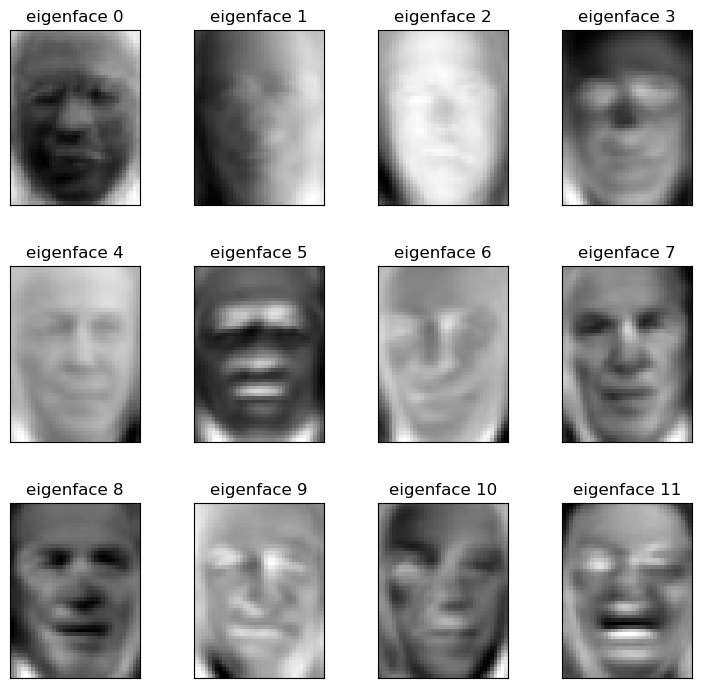

In [14]:
# Send back to CPU for further calcs
eigenfaces = eigenfaces.to('cpu').numpy()
X_train_transformed = X_train_transformed.to('cpu').numpy()
X_test_transformed = X_test_transformed.to('cpu').numpy()
S = S.to('cpu').numpy()

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

(912,)


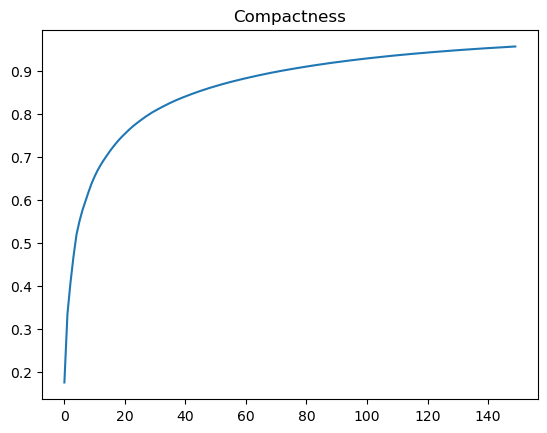

In [15]:
explained_variance = (S ** 2) / (n_samples - 1)
total_var = explained_variance.sum()
explained_variance_ratio = explained_variance / total_var
ratio_cumsum = np.cumsum(explained_variance_ratio)
print(ratio_cumsum.shape)

eigenvalueCount = np.arange(n_components)
plt.plot(eigenvalueCount, ratio_cumsum[:n_components])
plt.title('Compactness')

plt.show()

In [16]:
#build random forest
estimator = RandomForestClassifier(n_estimators=150, max_depth=15, max_features=150)
estimator.fit(X_train_transformed, y_train) #expects X as [n_samples, n_features]

predictions = estimator.predict(X_test_transformed)
correct = predictions==y_test
total_test = len(X_test_transformed)

print("Accuracy:",np.sum(correct)/total_test)
print(classification_report(y_test, predictions, target_names=target_names))

Accuracy: 0.6655737704918033
                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00        14
     Colin Powell       0.74      0.57      0.64        65
  Donald Rumsfeld       0.92      0.33      0.49        33
    George W Bush       0.64      0.95      0.76       133
Gerhard Schroeder       0.92      0.52      0.67        23
       Tony Blair       0.59      0.46      0.52        37

         accuracy                           0.67       305
        macro avg       0.63      0.47      0.51       305
     weighted avg       0.68      0.67      0.63       305

